In [1]:
import numpy as np

In [2]:
with open("/content/1.txt",'r') as file1:
    temp = file1.readlines()
    for i in range(len(temp)):
        temp[i]=float(temp[i][:-1])
    norm1 = np.array(temp)

In [3]:
with open("/content/4.txt",'r') as file1:
    temp = file1.readlines()
    for i in range(len(temp)):
        temp[i]=float(temp[i][:-1])
    norm2 = np.array(temp)

In [4]:
with open("/content/3.txt",'r') as file1:
    temp = file1.readlines()
    for i in range(len(temp)):
        temp[i]=float(temp[i][:-1])
    ind1 = np.array(temp)

In [5]:
with open("/content/6.txt",'r') as file1:
    temp = file1.readlines()
    for i in range(len(temp)):
        temp[i]=float(temp[i][:-1])
    ind2 = np.array(temp)

# Необходимо идентифицировать распределения в каждом файле двумя способами:
*  с помощью критерия согласия Пирсона
*  c методом анаморфоз


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression

In [7]:
def plot_histogram(stat):
    plt.figure(figsize = (7,4))
    plt.bar(stat['int'],stat['wi'], width=1.0, edgecolor = 'white')
    plt.xticks(fontsize = 8)
    plt.xlabel('x')
    plt.ylabel('w')
    plt.show()

def get_stat(data):
    m_ster = int(1 + np.log2(len(data)))
    print('Количество интервалов =', m_ster)
    len_iter=(data.max() - data.min())/m_ster #длина каждого частичного интервала
    minn = data.min() - 0.001

    intervals = []
    while minn < data.max() - len_iter/2:
        intervals.append([round(minn,2),round(minn+len_iter,2)])
        minn = minn + len_iter

    stat = pd.DataFrame(intervals)
    stat['ni'] = np.zeros(len(stat)).astype(int)

    for i in range(len(data)):
        for k in range(len(stat)):
            if stat.loc[k,0]<=data[i] and stat.loc[k,1]>=data[i]:
                stat.loc[k,'ni'] = stat.loc[k,'ni'] + 1

    stat['wi'] = stat['ni']/len(data)
    stat['int'] = stat[0].astype(str) +' '+ stat[1].astype(str)
    return stat

In [8]:
def pirs_norm(stat, data):
    mean = data.mean()
    std = data.std()
    #получение теоретических частот нормального распределения
    stat['Pi'] = (scipy.stats.norm.cdf((stat[1]-mean)/std) - 0.5) - \
                        (scipy.stats.norm.cdf((stat[0]-mean)/std) - 0.5)
    stat['nP'] = stat['Pi'] * len(data)
    Xi2 = sum((stat['ni']-stat['nP'])**2/stat['nP']) #полученное значение критерия Пирсона

    #Критическое значение берем из таблицы
    k = len(stat) - 2 - 1 #число степеней свободы = кол-во интервалов - кол-во параметров распр - 1
    Xi2teor = scipy.stats.chi2.ppf(0.95, k)

    print(f'Полученное значение критерия Пирсона {round(Xi2,2)}, критическое значение {round(Xi2teor,2)}')
    if Xi2 < Xi2teor:
        print('Выборка принадлежит нормальному распределению')
    else:
        print('Выборка НЕ принадлежит нормальному распределению')

Количество интервалов = 8


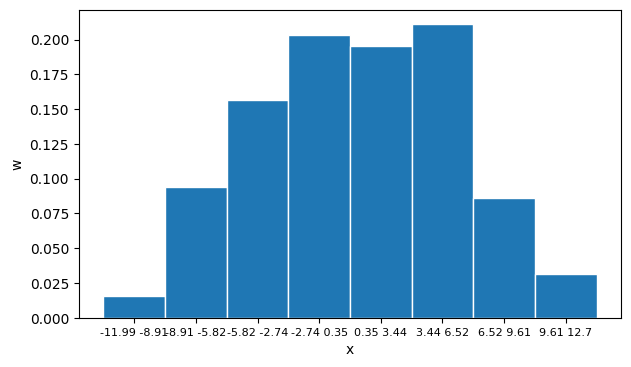

Полученное значение критерия Пирсона 3.87, критическое значение 11.07
Выборка принадлежит нормальному распределению

Количество интервалов = 6


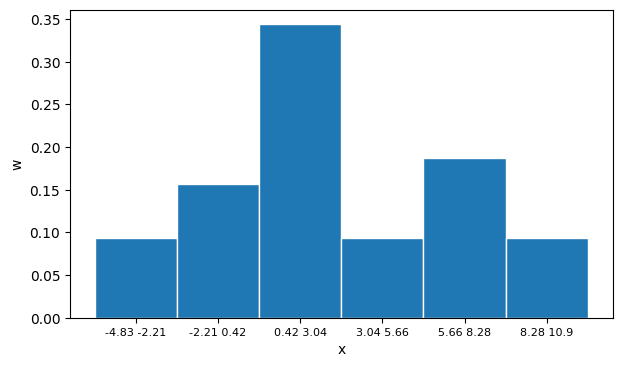

Полученное значение критерия Пирсона 5.16, критическое значение 7.81
Выборка принадлежит нормальному распределению

Количество интервалов = 8


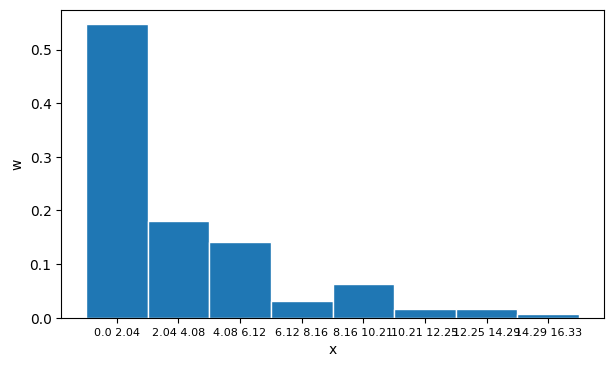

Полученное значение критерия Пирсона 145.9, критическое значение 11.07
Выборка НЕ принадлежит нормальному распределению

Количество интервалов = 6


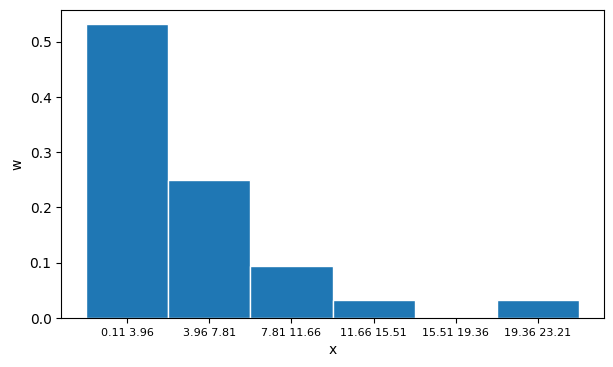

Полученное значение критерия Пирсона 23.13, критическое значение 7.81
Выборка НЕ принадлежит нормальному распределению


In [9]:
stat_n_128 = get_stat(norm2)
plot_histogram(stat_n_128)
pirs_norm(stat_n_128, norm2)
print()

stat_n_32 = get_stat(norm1)
plot_histogram(stat_n_32)
pirs_norm(stat_n_32, norm1)
print()

stat_e_128 = get_stat(ind2)
plot_histogram(stat_e_128)
pirs_norm(stat_e_128, ind2)
print()

stat_e_32 = get_stat(ind1)
plot_histogram(stat_e_32)
pirs_norm(stat_e_32, ind1)

In [ ]:
def anam(stat, data):
    stat = stat.drop(stat['ni'][stat['ni'] == 0].index,axis='index') #удаление интервалов с 0
    mean = data.mean()
    m_ster = int(1 + np.log2(len(data)))
    len_iter=(data.max() - data.min())/m_ster #длина каждого частичного интервала
    stat['x'] = stat[0] + len_iter/2 #середины интервалов


    x_norm = (stat['x']-mean)**2
    y_norm  = np.log(stat['wi'])

    x_exp = stat['x']
    y_exp = np.log(stat['wi'])

    model_norm = LinearRegression()
    model_norm.fit(x_norm.values.reshape((-1,1)),y_norm.values)
    k_norm=model_norm.coef_[0]

    model_exp = LinearRegression()
    model_exp.fit(x_exp.values.reshape((-1,1)),y_exp.values)
    k_exp=model_exp.coef_[0]

    fig, ax = plt.subplots(1,3, figsize = (13,4))
    fig.tight_layout(pad = 2)
    ax[0].bar(stat['int'],stat['wi'], width=1.0, edgecolor = 'white')
    ax[0].tick_params('x', rotation = 60)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('w')
    ax[0].set_title('Гистограмма')

    ax[1].set_xlabel("(x-mean)^2")
    ax[1].set_ylabel("ln(w)")
    ax[1].scatter(x_norm,y_norm, s=100)
    ax[1].plot(x_norm,model_norm.predict(x_norm.values.reshape((-1,1))), color = 'green',
               label = 'R2: '+ str(round(model_norm.score(x_norm.values.reshape((-1,1)),y_norm.values), 2)))
    ax[1].legend()
    ax[1].set_title('Нормальное распределение')

    ax[2].set_xlabel("x")
    ax[2].set_ylabel("ln(w)")
    ax[2].scatter(x_exp,y_exp, s=100)
    ax[2].plot(x_exp,model_exp.predict(x_exp.values.reshape((-1,1))), color = 'green',
               label = 'R2: '+ str(round(model_exp.score(x_exp.values.reshape((-1,1)),y_exp.values), 2)))
    ax[2].legend()
    ax[2].set_title('Показательное распределение')

    plt.show()

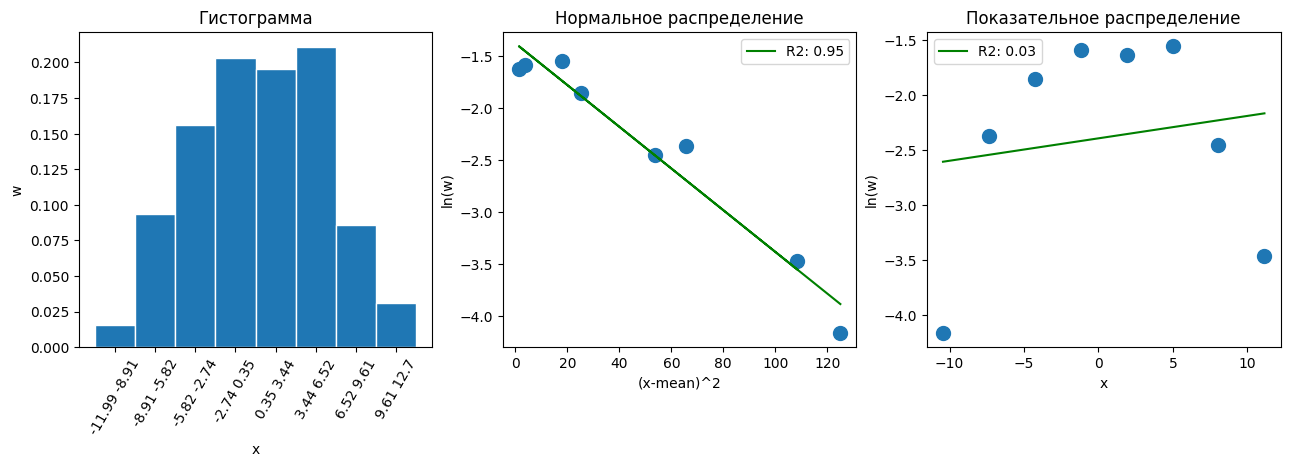

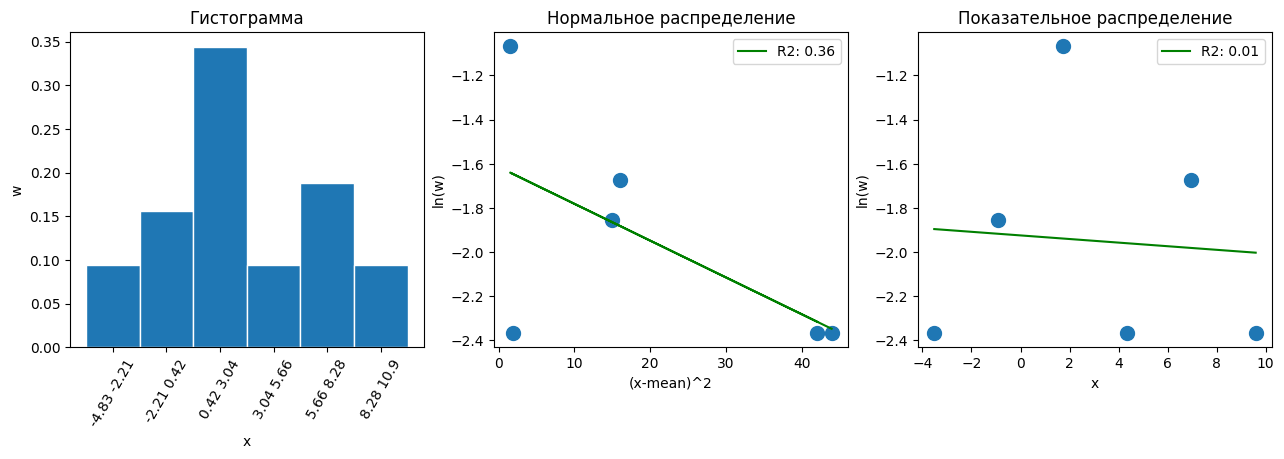

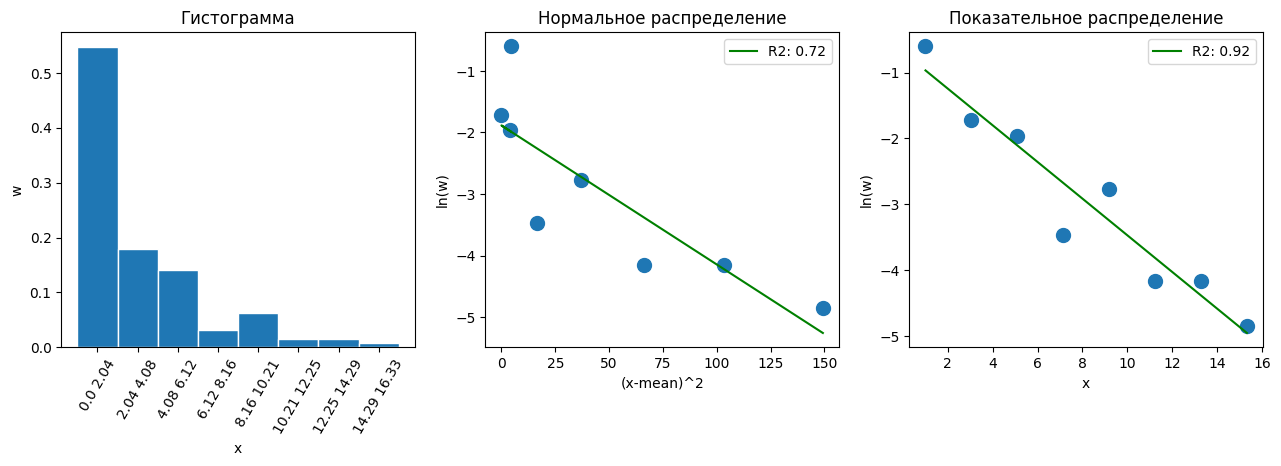

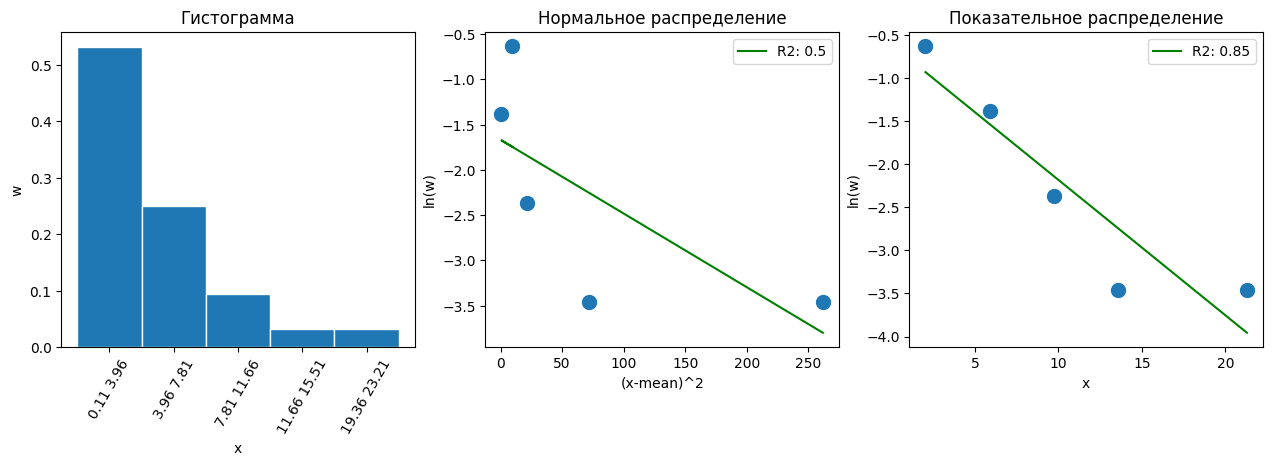

In [ ]:
anam(stat_n_128, norm2)
anam(stat_n_32, norm1)

anam(stat_e_128, ind2)
anam(stat_e_32, ind1)